1. Data Collection

Load dataset

In [103]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("medquad.csv")

# Display the first 5 rows of the dataset
df.head()


,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


2.Exploratory Data Analysis (EDA)

Overview of Dataset Structure

In [89]:
print("📌 Columns:", list(df.columns))
print("📊 Number of rows:", len(df))

# Check for missing values
print("\n❗ Missing values per column:\n", df.isnull().sum())

# Sample questions
print("\n🔀 Sample questions:\n", df['question'].sample(5, random_state=42).to_string(index=False))


📌 Columns: ['question', 'answer', 'source', 'focus_area']
📊 Number of rows: 16412

❗ Missing values per column:
 question       0
answer         5
source         0
focus_area    14
dtype: int64

🔀 Sample questions:
 What are the genetic changes related to leukoen...
        What to do for Primary Biliary Cirrhosis ?
          Who is at risk for Fecal Incontinence? ?
 What is (are) Pervasive Developmental Disorders ?
         What are the symptoms of Crome syndrome ?


random questions, and answer length distribution.

In [90]:
print(df['question'].sample(5))


8488             What are the treatments for Hemophilia ?
7175    What are the symptoms of Charcot-Marie-Tooth d...
1377                   What is (are) Male Breast Cancer ?
1066              How to diagnose AIDS-Related Lymphoma ?
3669    What are the symptoms of Yorifuji Okuno syndro...
Name: question, dtype: object


Check for Missing Values (NaN)

In [104]:
# 1. Count missing values (NaN) in each column
print("Missing values (NaN) per column:")
print(df.isnull().sum())

Missing values (NaN) per column:
question       0
answer         5
source         0
focus_area    14
dtype: int64


Extract QA Pairs

In [92]:
qa_df = df[['question', 'answer']]
qa_df.head()


,question,answer
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea..."
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ..."
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...


Select Relevant Columns and Drop Incomplete Rows


In [93]:
# Keep only the essential columns for QA tasks and remove rows with missing questions or answers.
df = df[['question','answer','source','focus_area']].dropna(subset=['question','answer']).reset_index(drop=True)
print(df.shape)
df.head(3)

(16407, 4)


,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma


Answer Length Distribution

In [94]:
# Add columns for text length
df['q_len'] = df['question'].str.len()
df['a_len'] = df['answer'].str.len()

# Stats on answer length
print("\n📏 Answer length (characters):\n", df['a_len'].describe())



📏 Answer length (characters):
 count    16407.000000
mean      1303.452673
std       1656.694326
min          6.000000
25%        487.000000
50%        890.000000
75%       1589.000000
max      29046.000000
Name: a_len, dtype: float64


Plot: Histogram of Answer Lengths

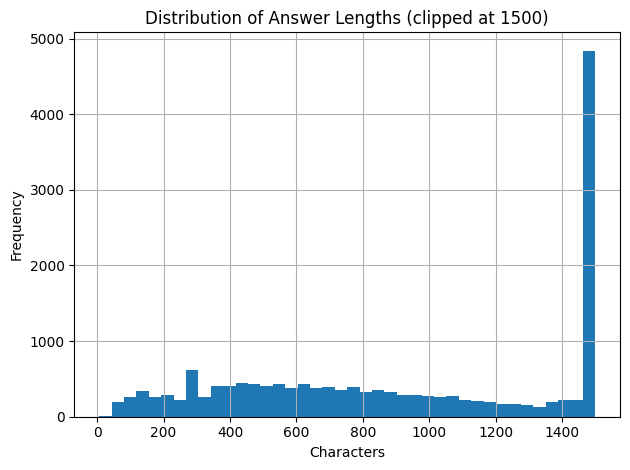

In [95]:
import matplotlib.pyplot as plt

plt.figure()
df['a_len'].clip(0, 1500).hist(bins=40)
plt.title("Distribution of Answer Lengths (clipped at 1500)")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


Plot: Top 20 Focus Areas

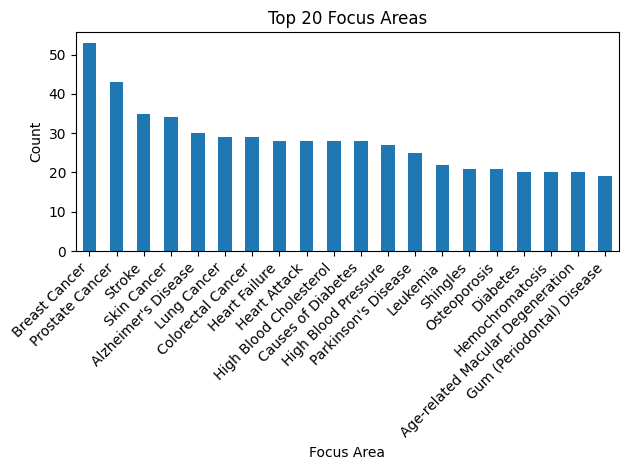

In [96]:
if 'focus_area' in df.columns:
    top_focus = df['focus_area'].value_counts().head(20)
    
    plt.figure()
    top_focus.plot(kind='bar')
    plt.title("Top 20 Focus Areas")
    plt.xlabel("Focus Area")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Text Cleaning & Preparation

Basic Text Cleaning

In [97]:
import re

def clean_text(s: str) -> str:
    s = str(s).strip()
    s = re.sub(r'\s+', ' ', s)  # replace multiple spaces/tabs/newlines with a single space
    return s

# Apply cleaning function
df['question'] = df['question'].apply(clean_text)
df['answer']   = df['answer'].apply(clean_text)


Drop Empty Questions/Answers

In [98]:
# Remove rows with missing or now-empty fields
df = df.dropna(subset=['question', 'answer'])


Final Dataset Preview

In [99]:
print("✅ Dataset shape after cleaning:", df.shape)
df.head(3)

✅ Dataset shape after cleaning: (16407, 6)


,question,answer,source,focus_area,q_len,a_len
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma,24,1850
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma,22,1209
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in o...,NIHSeniorHealth,Glaucoma,35,1607


3. Data Preprocessing - Baseline Model

In [100]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Extraire les données
questions = df['question'].astype(str).tolist()
answers = df['answer'].astype(str).tolist()

# 2. Tokenizer (limite vocabulaire pour baseline)
num_words = 5000
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(questions + answers)

# 3. Encodage
X_seq = tokenizer.texts_to_sequences(questions)
y_seq = tokenizer.texts_to_sequences(answers)

# 4. Padding (aligner les séquences à la même taille)
max_len_q = max(len(x) for x in X_seq)
max_len_a = max(len(x) for x in y_seq)

X_pad = pad_sequences(X_seq, maxlen=max_len_q, padding='post')
y_pad = pad_sequences(y_seq, maxlen=max_len_a, padding='post')

# 5. Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_pad, test_size=0.2, random_state=42)

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Dimensions
embedding_dim = 64
hidden_dim = 128

model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len_q),
    LSTM(hidden_dim),
    Dense(num_words, activation='softmax')  # prédiction sur le vocabulaire
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement (baseline rapide)
history = model.fit(X_train, y_train[:,0],  # simplification: prédire le 1er mot de la réponse
                    epochs=3,
                    validation_data=(X_test, y_test[:,0]))

Epoch 1/3


c:\Users\yaako\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


411/411 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.1676 - loss: 4.8778 - val_accuracy: 0.1862 - val_loss: 4.5311
Epoch 2/3
411/411 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.1709 - loss: 4.4468 - val_accuracy: 0.1862 - val_loss: 4.5278
Epoch 3/3
411/411 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.1709 - loss: 4.4353 - val_accuracy: 0.1862 - val_loss: 4.5292


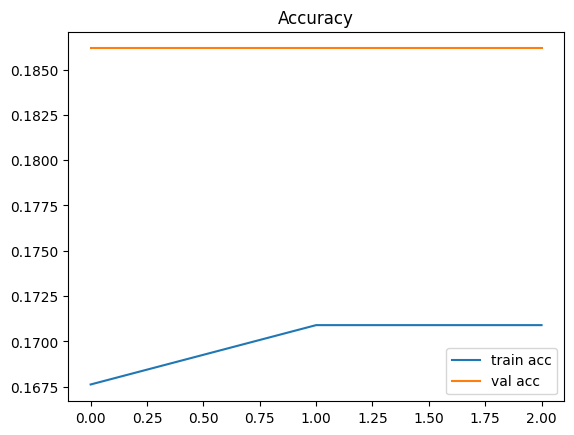

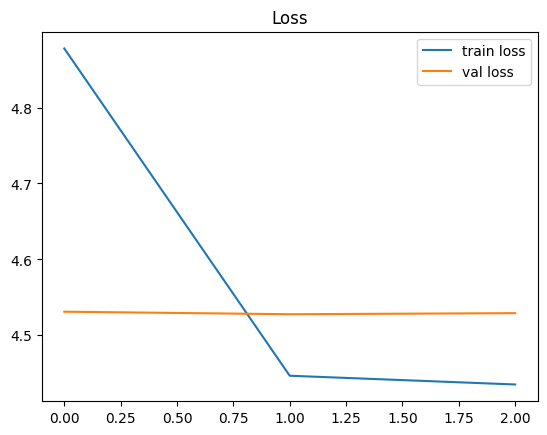

In [102]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy")
plt.show()

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss")
plt.show()